# B4S3 Regresión Polinómica y de Variables Dummy

- [1. Regresión Polinómica](#1.-Regresión-Polinómica)
- [2. Variables Dummy](#2.-Variables-Dummy)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

%matplotlib inline
plt.style.use('seaborn-white')

### Carga de los datos
Datos basados en el libro ISLR de ingresos

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Wage.csv')
df.head(3)

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3000 non-null   int64  
 1   year        3000 non-null   int64  
 2   age         3000 non-null   int64  
 3   sex         3000 non-null   object 
 4   maritl      3000 non-null   object 
 5   race        3000 non-null   object 
 6   education   3000 non-null   object 
 7   region      3000 non-null   object 
 8   jobclass    3000 non-null   object 
 9   health      3000 non-null   object 
 10  health_ins  3000 non-null   object 
 11  logwage     3000 non-null   float64
 12  wage        3000 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 304.8+ KB


# 1. Regresión Polinómica

Se crean polinomios para 'age'. (Estos corresponden a los de R, cuando se usa raw=TRUE en la función poly().

In [5]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).values
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 [1.000000e+00 4.300000e+01 1.849000e+03 7.950700e+04 3.418801e+06]
 [1.000000e+00 5.000000e+01 2.500000e+03 1.250000e+05 6.250000e+06]]
y:
 [0 0 0 0 0]


#### Modelo de Regresión Lineal. (Grado 4)

In [6]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Selección de un grado adecuado para el polinomio en age.

In [7]:
fit_1 =  sm.GLS(df.wage, X1).fit()
fit_2 =  sm.GLS(df.wage, X2).fit()
fit_3 =  sm.GLS(df.wage, X3).fit()
fit_4 =  sm.GLS(df.wage, X4).fit()
fit_5 =  sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


El mejor polinomio parece ser el de grado 4.

In [8]:
X = X4

Scikit-learn implementa un modelo de regresión logística regularizado especialmente adecuado para datos de alta dimensión. Como solo tenemos una característica (age), usamos el modelo GLM de statsmodels.

In [9]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

<ipython-input-9-c3941130c8c6>:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))


Cree una matriz de datos de prueba. Transforme al polinomio de grado 4 y ejecute la predicción. 

In [10]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In [11]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

### Figure 7.1

C:\Users\jgeis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


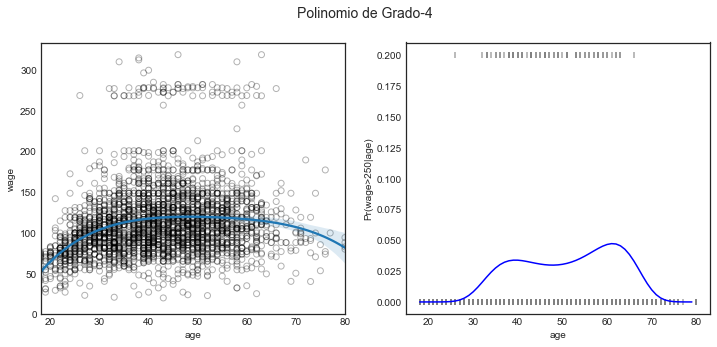

In [12]:
# Creación de gráficos
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Polinomio de Grado-4', fontsize=14)

# Gráfico de Dispersión con recta de regresión polinomial
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Regresión logística que muestra Pr(wage>250) para el rango de 'age'.
ax2.plot(age_grid, pred, color='b')

# Gráfico que muestra la distribución de wage>250 en los datos de entrenamiento.
# 'True' en  la parte superior, 'False' en la parte inferior.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

#### Variables Dummy

In [13]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [14]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
0,18,"(17.938, 33.5]",75.043154
1,24,"(17.938, 33.5]",70.476020
2,45,"(33.5, 49.0]",130.982177
3,43,"(33.5, 49.0]",154.685293
4,50,"(49.0, 64.5]",75.043154


# 2. Variables Dummy

In [15]:
# Creación de variables dummy para los grupos de edad
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requiere que explicitamente se agregue una constante (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

#df_steps_dummies
df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
0,1.0,1,0,0,0
1,1.0,1,0,0,0
2,1.0,0,1,0,0
3,1.0,0,1,0,0
4,1.0,0,0,1,0


In [16]:
# Usamos statsmodels porque tiene una salida más completa para los coeficientes
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [17]:
# Poner los datos de pruebaen los mismos bins que los datos de entrenamiento.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [18]:
# Se obtienen las variables dummy, se elimina la primera categoría dummy, y se agrega una constante
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


#### Linear Regression

In [19]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [20]:
clf2 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial(sm.families.links.logit()))
#Esto traía un deprecation warning, resuelto con: https://github.com/statsmodels/statsmodels/issues/6807
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

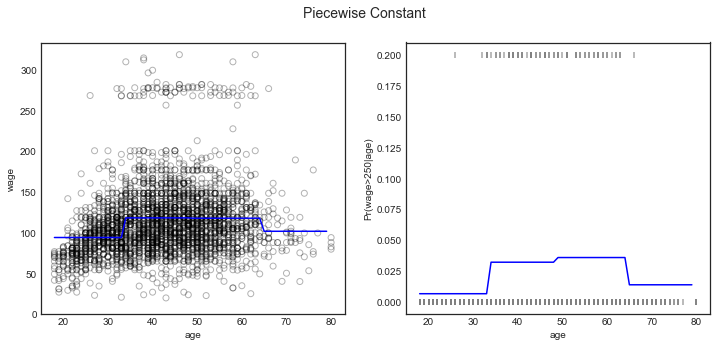

In [21]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');